In [1]:
import onnxruntime as ort
import tensorflow as tf
import json 
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

2024-05-25 21:45:00.130954: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-25 21:45:00.154762: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 21:45:00.154783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 21:45:00.155707: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-25 21:45:00.160091: I tensorflow/core/platform/cpu_feature_guar

### Cropping Function

In [2]:
cropping_params = {
    "ad_erzieher_name":         {"left": 0.15, "bottom": 0},
    "ad_erzieher_vorname":      {"left": 0.15, "bottom": 0},
    "ad_erzieher_tel":          {"left": 0.2, "bottom": 0},
    "ad_erzieher_email":        {"left": 0.15, "bottom": 0},
    "schueler_name":            {"left": 0.15, "bottom": 0},
    "schueler_vorname":         {"left": 0.15, "bottom": 0},
    "schueler_klasse":          {"left": 0.125, "bottom": 0},
    "ad_neue_ad_str_haus_nr":   {"left": 0.275, "bottom": 0},
    "ad_neue_ad_plz":           {"left": 0.25, "bottom": 0},
    "ad_neue_ad_stadt":         {"left": 0.15, "bottom": 0},
    "ad_schueler_datum":        {"left": 0.2, "bottom": 0},
    "ag_auswahl_wahl_1":        {"left": 0.15, "bottom": 0},
    "ag_auswahl_wahl_2":        {"left": 0.15, "bottom": 0},
    "ag_auswahl_wahl_3":        {"left": 0.15, "bottom": 0},
    "ag_schueler_datum":        {"left": 0.3, "bottom": 0},
    "ad_schueler_unterschrift": {"left": 0.2, "bottom": 0}, 
    "ag_schueler_unterschrift": {"left": 0.2, "bottom": 0}, 
}

In [3]:
def crop(x1, y1, x2, y2, image, crop_left_percent, crop_bottom_percent):
    crop_left = int(crop_left_percent * (x2 - x1))
    crop_bottom = int(crop_bottom_percent * (y2 - y1))
    cropped_image = image[y1 + crop_bottom:y2, x1 + crop_left:x2]
    if cropped_image.size == 0:
        print("Cropped image is empty")
        return None
    return cropped_image

### Inference

In [4]:
def prediction_on_image_inference(test_img, onnx_file_path, class_names, threshold=0.8, img_size=(1024, 1024)):
    original_height, original_width = test_img.shape[:2]
    print(f'Original image size: {original_height}x{original_width}')
    
    # Resize the test image
    input_img = tf.image.resize(test_img, img_size)

    # Transform the input tensor to match the expected format 
    input_img = tf.expand_dims(input_img, axis=0)
    input_img = tf.transpose(input_img, perm=[0, 3, 1, 2])
    input_img = np.array(input_img, np.float32) / 255.0
    
    # Load the model and create an InferenceSession
    session = ort.InferenceSession(onnx_file_path, providers=['GPUExecutionProvider', 'CPUExecutionProvider'])
    model_output = session.run(None, {"input": input_img})

    # Filter the output based on the confidence threshold
    scores_mask = model_output[2] > threshold

    pred_bounding_boxes = (model_output[0][scores_mask])
    pred_labels = [class_names[int(idx)] for idx in model_output[1][scores_mask]]
    pred_scores = model_output[2]
    
    # Combine the bounding boxes, labels, and confidence scores
    results = []
    for label, box, score in zip(pred_labels, pred_bounding_boxes, pred_scores):
        x_min, y_min, x_max, y_max = box
        x_min = int(x_min * original_width / img_size[1])
        y_min = int(y_min * original_height / img_size[0])
        x_max = int(x_max * original_width / img_size[1])
        y_max = int(y_max * original_height / img_size[0])
        box = [x_min, y_min, x_max, y_max]
        results.append((label, box, score.item()))

###### Display the image with bounding boxes ######
    # Convert the test image to a format suitable for drawing
    test_img_np = test_img.numpy()
    test_img_np = cv2.cvtColor(test_img_np, cv2.COLOR_RGB2BGR)

    # Draw the bounding boxes on the image
    for label, box, score in results:
        x_min, y_min, x_max, y_max = box
        cv2.rectangle(test_img_np, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(test_img_np, f'{label}: {score:.2f}', (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
    
    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(test_img_np, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return results

### Start

In [5]:
model_dir = "/mnt/c/Users/jason/GitHubRepos/LectorAI-TextExtraction/TOP_AMAZON_WORKER/mask_rcnn" # use absolute path, model's folder
weights_file = "Bilder-maskrcnn_resnet50_fpn_v2.onnx"

# Convert the paths to Path objects
checkpoint_dir_obj = Path(model_dir)

# Set a filename for the ONNX model
onnx_file_path = f"{model_dir}/{weights_file}"

In [6]:
test_file = '/mnt/c/Users/jason/GitHubRepos/LectorAI-TextExtraction/tempimages_api/beispiel_form.jpg' # use absolute path, ag/ad Bild
test_img = tf.io.read_file(test_file)
test_img = tf.image.decode_png(test_img, channels=3)

# Find the colormap JSON file in the directory
colormap_path = list(checkpoint_dir_obj.glob('*colormap.json'))[0]

# Load the JSON colormap data
with open(colormap_path, 'r') as file:
    colormap_json = json.load(file)

# Convert the JSON data to a dictionary        
colormap_dict = {item['label']: item['color'] for item in colormap_json['items']}

# Extract the class names from the colormap
class_names = list(colormap_dict.keys())

2024-05-25 21:45:02.020978: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-25 21:45:02.045496: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-25 21:45:02.045578: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-25 21:45:02.047936: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-25 21:45:02.047994: I external/local_xla/xla/stream_executor

Original image size: 2164x1556


/home/sonotokay/miniconda3/envs/everything/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'GPUExecutionProvider' is not in available provider names.Available providers: 'TensorrtExecutionProvider, CUDAExecutionProvider, AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
2024-05-25 21:45:03.325723123 [W:onnxruntime:, graph.cc:4093 CleanUnusedInitializersAndNodeArgs] Removing initializer '3114'. It is not used by any node and should be removed from the model.


*************** EP Error ***************
EP Error Unknown Provider Type: GPUExecutionProvider when using ['GPUExecutionProvider', 'CPUExecutionProvider']
Falling back to ['CPUExecutionProvider'] and retrying.
****************************************


2024-05-25 21:45:04.146644605 [W:onnxruntime:, graph.cc:4093 CleanUnusedInitializersAndNodeArgs] Removing initializer '3114'. It is not used by any node and should be removed from the model.


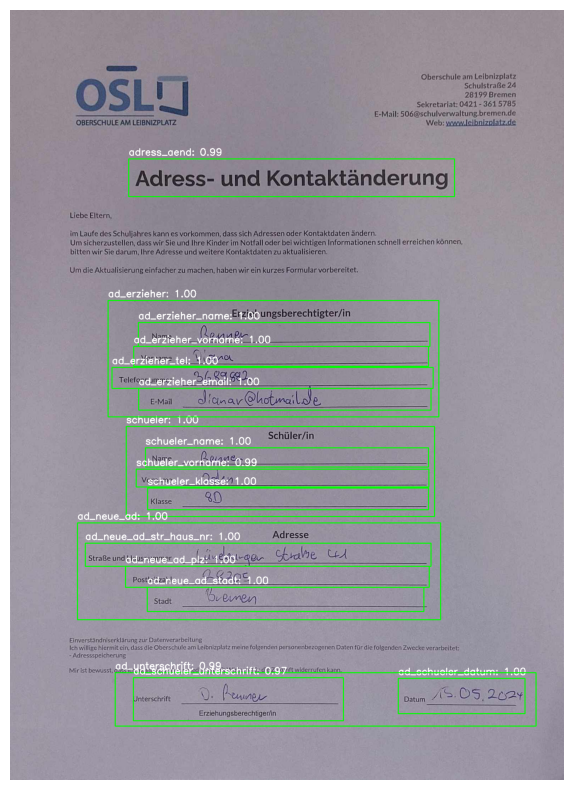

In [7]:
results = prediction_on_image_inference(test_img, onnx_file_path, class_names)

Label: schueler, Box: [326, 1170, 1192, 1423], Confidence: 0.9991846680641174
Label: ad_erzieher_email, Box: [361, 1063, 1182, 1124], Confidence: 0.9990725517272949
Label: ad_neue_ad, Box: [189, 1441, 1209, 1713], Confidence: 0.9990106821060181
Label: ad_erzieher_name, Box: [360, 878, 1179, 945], Confidence: 0.9989200830459595
Label: ad_erzieher_vorname, Box: [347, 945, 1175, 1001], Confidence: 0.9983499050140381
Label: ad_erzieher, Box: [275, 816, 1204, 1143], Confidence: 0.9982771873474121
Label: schueler_klasse, Box: [386, 1343, 1175, 1404], Confidence: 0.9979598522186279
Label: ad_erzieher_tel, Box: [286, 1004, 1188, 1063], Confidence: 0.9977535605430603
Label: ad_neue_ad_plz, Box: [324, 1563, 1177, 1622], Confidence: 0.9972631931304932
Label: ad_neue_ad_str_haus_nr, Box: [211, 1498, 1182, 1563], Confidence: 0.9971454739570618
Label: ad_neue_ad_stadt, Box: [385, 1622, 1162, 1690], Confidence: 0.9967401623725891
Label: schueler_name, Box: [380, 1230, 1175, 1284], Confidence: 0.99627

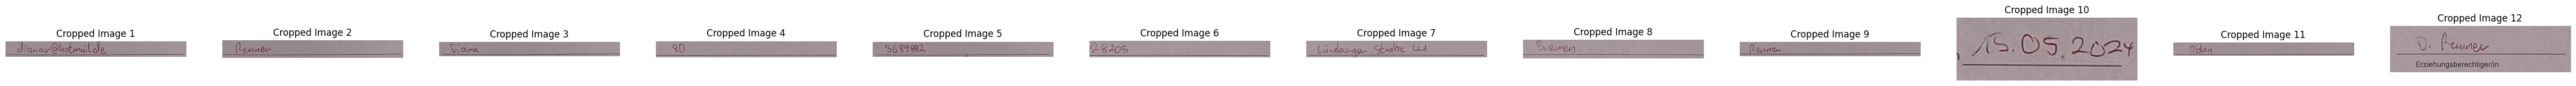

In [8]:
# Display the results
cropped_images = []
test_img_np = test_img.numpy()
test_img_np = cv2.cvtColor(test_img_np, cv2.COLOR_RGB2BGR)
for label, box, score in results:
    print(f"Label: {label}, Box: {box}, Confidence: {score}")
    x_min, y_min, x_max, y_max = box
    crop_left_percent = 0
    crop_bottom_percent = 0
    if label not in cropping_params:
        continue
    params = cropping_params[label]
    crop_left_percent = float(params["left"])
    crop_bottom_percent = float(params["bottom"])
    cropped_image = crop(x_min, y_min, x_max, y_max, test_img_np, crop_left_percent, crop_bottom_percent)
    cropped_images.append(cropped_image)

num_images = len(cropped_images)
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, num_images * 5))
for i, cropped_img in enumerate(cropped_images):
    axes[i].imshow(cropped_img)
    axes[i].axis('off')
    axes[i].set_title(f'Cropped Image {i+1}')
plt.show()